In [1]:
import glob
import os 

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import files
import occupancy
import wait_times
import vehicles

# General Utils

In [3]:
SCENARIOS_PATH = r"E:/Files/CodeProjects/MATSim/Scenarios/"
RUN_DIR = "runner-tests/9"
PATH = os.path.join(SCENARIOS_PATH, RUN_DIR)

# Wait time utils

In [4]:
r = files.iterate_algorithms(PATH, wait_times.get_wait_stats)
pd.DataFrame(r).stack().unstack(level=-2)

output for RUN_ID: 9, from func: get_wait_stats


,mean wait,95p wait
DRT,597.540000,1279.90
DynamicRideSharingStrategy,315.806875,591.05
ExtDemandSupplyBeamSharing,287.869375,604.20
HighCapacityDispatcher,490.124375,1294.40
TShareDispatcher,275.153750,590.05


# Population Utils

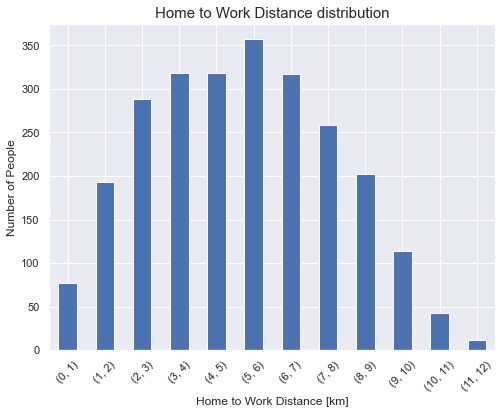

In [5]:
bin_size_meters = 2000
def get_origin_destination_data(alg_path):
    pop_filename = "Population*.xml.DistanceInfo.csv"
    path = glob.glob(os.path.join(alg_path, pop_filename))[0]
    df = pd.read_csv(path, names=["person", "distance"], skiprows=1)
    return pd.cut(df["distance"], include_lowest=True, bins=range(1,25000, bin_size_meters))


out = get_origin_destination_data(PATH+"/DRT")
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(8,6))
ticks = [(int(c.left//bin_size_meters), int(c.right//bin_size_meters)) 
         for c in out.cat.categories]
ax.set_xticklabels(ticks)

ax.set_title("Home to Work Distance distribution")
ax.title.set_size(15)
ax.set_xlabel("Home to Work Distance [km]")
ax.set_ylabel("Number of People")
plt.xticks(rotation=45)
plt.show()

# Fleet distance

In [6]:
r = files.iterate_algorithms(PATH, vehicles.get_distances_stats)
pd.DataFrame(r).stack().unstack(level=-2) / 1000

output for RUN_ID: 9, from func: get_distances_stats


,total distance,total empty distance,empty ratio
DRT,7863.60000,916.400000,0.000120
DynamicRideSharingStrategy,5846.06400,3209.014622,0.000549
ExtDemandSupplyBeamSharing,3213.68928,527.814223,0.000164
HighCapacityDispatcher,3646.13952,894.665148,0.000245
TShareDispatcher,3310.98144,575.058115,0.000174


# Ocuupancy utils

In [7]:
from importlib import reload

reload(occupancy)

df = files.iterate_algorithms(PATH, occupancy.get_ocucpancy_aggregation)
df = pd.DataFrame(df).stack().unstack(level=-2).fillna(0)
df.style.format({col: '{:,.2f}%'
                 for col in df.columns})

output for RUN_ID: 9, from func: get_ocucpancy_aggregation


output for RUN_ID: 9, from func: get_occupancy_per_hour


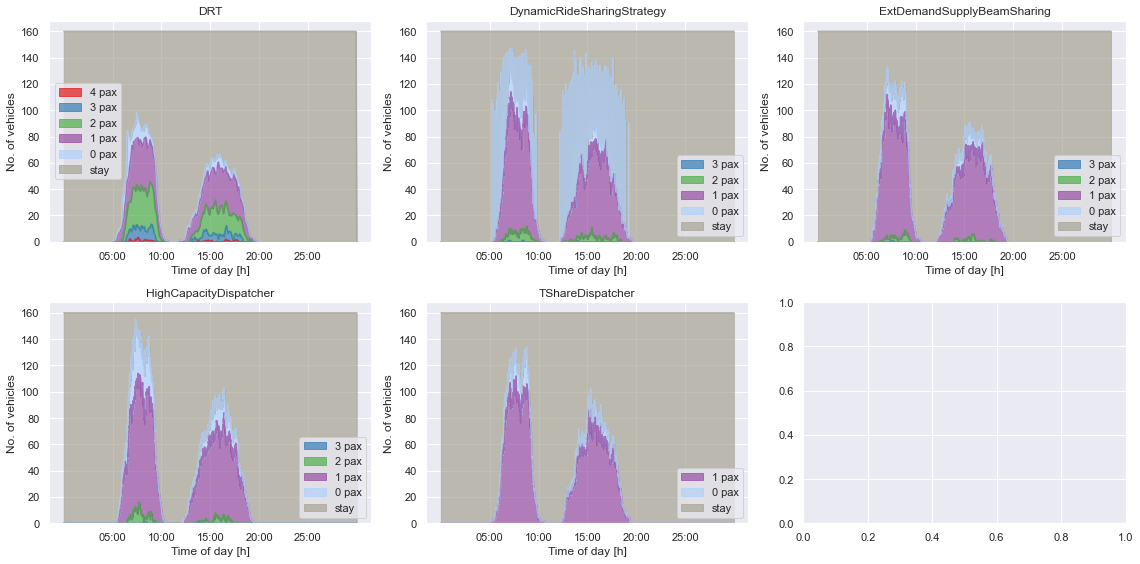

In [8]:
occupancy_dfs = files.iterate_algorithms(PATH, occupancy.get_occupancy_per_hour)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
for i, alg in enumerate(occupancy_dfs.keys()):
    ax = axes[i//3][i%3]
    occupancy.plot_occuancy_data(occupancy_dfs[alg], alg, ax)
fig.tight_layout()

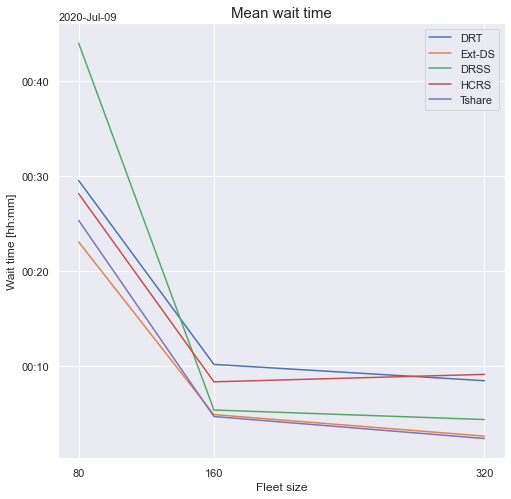

In [11]:
import matplotlib.dates as mdates

data = [["0:29:31", "0:23:03", "0:43:58", "0:28:08", "0:25:19"],
["0:10:10", "0:04:53", "0:05:22", "0:08:20", "0:04:41"],
["0:08:27", "0:02:37", "0:04:22", "0:09:07", "0:02:22"]]

# data = [["1:24:57", "1:15:22", "2:05:10", "1:42:02", "2:00:16"],
# ["0:21:47", "0:10:17", "0:10:04", "0:22:02", "0:10:03"],
# ["0:20:19", "0:06:46", "0:08:11", "0:23:09", "0:05:34"]]
cols = ["DRT", "Ext-DS", "DRSS", "HCRS", "Tshare"]
x = [80,160,320]
df = pd.DataFrame(data, index=x, columns=cols)
for c in cols:
    df[c] = pd.to_datetime(df[c])

ax = df.plot(figsize=(8,8))
ax.set_xticks(x)
ax.set_xlabel("Fleet size")

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.yaxis.set_major_locator(locator)
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel("Wait time [hh:mm]")

ax.set_title("Mean wait time")
ax.title.set_size(15)